In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

import math
import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.scripts.eval import eval_setup
from nerfstudio.models.instant_ngp import NGPModel

import torch.utils.checkpoint as checkpoint

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Process ForkProcess-1:
Process ForkProcess-2:


In [2]:
# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Get the number of CUDA devices
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    
    # Get the name of the current CUDA device
    print(f"Current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    
    # Get device properties
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Total memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

CUDA available: True
CUDA device count: 1
Current CUDA device: NVIDIA A100-SXM4-80GB
Device 0: NVIDIA A100-SXM4-80GB
  Total memory: 84.97 GB


In [3]:
def extract_model_for_backprop(config_path, eval_num_rays_per_chunk=None):
    # Load the model and pipeline using eval_setup
    config, pipeline, checkpoint_path, step = eval_setup(
        config_path=Path(config_path),
        eval_num_rays_per_chunk=eval_num_rays_per_chunk,
        test_mode="val"  # Use validation set
    )
    
    # Extract the model from the pipeline
    model = pipeline.model
    
    # Make sure model is in evaluation mode but with gradients enabled
    model.eval()
    
    # Define a function to render a full image and allow backpropagation
    def render_full_image_with_grad(camera_idx=0):
        # Get a camera from the dataset
        cameras = pipeline.datamanager.eval_dataset.cameras
        camera = cameras[camera_idx:camera_idx+1].to(model.device)
        
        # Generate rays for the full image
        height, width = cameras.height[camera_idx].item(), cameras.width[camera_idx].item()
        
        # Create a grid of pixel coordinates
        y, x = torch.meshgrid(
            torch.arange(height, device=model.device),
            torch.arange(width, device=model.device),
            indexing='ij'
        )
        pixel_coords = torch.stack([y.flatten(), x.flatten()], dim=-1)  # [H*W, 2]
        
        # Generate flat ray bundle
        ray_bundle = camera.generate_rays(
            camera_indices=torch.zeros(pixel_coords.shape[0], 1, device=model.device, dtype=torch.int64),
            coords=pixel_coords
        )
        
        # Process in chunks to avoid OOM
        num_rays = len(ray_bundle)
        chunk_size = model.config.eval_num_rays_per_chunk
        
        def process_ray_chunk(ray_chunk):
            return model.get_outputs(ray_chunk)

        # Then in your loop:
        with torch.set_grad_enabled(True):
            outputs_lists = defaultdict(list)
            for i in range(0, num_rays, chunk_size):
                ray_chunk = ray_bundle[i:i+chunk_size]
                # Use checkpointing to reduce memory usage
                outputs_chunk = checkpoint.checkpoint(process_ray_chunk, ray_chunk)
                for key, value in outputs_chunk.items():
                    outputs_lists[key].append(value)
            
            # Combine chunks
            outputs = {}
            for key, value_list in outputs_lists.items():
                outputs[key] = torch.cat(value_list, dim=0)
            
            # Reshape to image dimensions
            for key, value in outputs.items():
                if len(value.shape) > 1:  # Only reshape tensors that have spatial dimensions
                    outputs[key] = value.reshape(height, width, -1)
            
            return outputs, height, width
    
    return model, pipeline, render_full_image_with_grad

In [10]:
def visualize_rgb_tensor(tensor):
    # Handle different tensor formats
    if tensor.shape[0] == 3 and len(tensor.shape) == 3:
        # If tensor is in format [3, H, W] (channel-first), permute to [H, W, 3]
        tensor = tensor.permute(1, 2, 0)
    
    # Convert to numpy and ensure values are between 0 and 1
    if tensor.max() > 1.0:
        # Assuming values are between 0-255
        np_img = tensor.cpu().numpy() / 255.0
    else:
        # Values already between 0-1
        np_img = tensor.cpu().numpy()
    
    # Clip to valid range
    np_img = np.clip(np_img, 0, 1)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis('off')
    plt.show()

In [5]:
# 1. Extract the model and render function
model, pipeline, render_full_image_with_grad = extract_model_for_backprop("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml", eval_num_rays_per_chunk=1024)

# 2. Render a full image with gradient tracking enabled
with torch.no_grad():
    outputs, height, width = render_full_image_with_grad(camera_idx=0)
rgb_image = outputs['rgb']  # This will be a height x width x 3 tensor

[21:27:33] Auto image downscale factor of 1                                                 ]8;id=725778;file:///n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=45996;file:///n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\

Setting up training dataset...

/n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Caching all 91 images.

Output()

Setting up evaluation dataset...

Caching all 10 images.

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

/n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/n/home10/dpodolskyi/.conda/envs/nerf-inversion/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain cur

In [6]:
rgb_image, rgb_image.shape

(tensor([[[1.5931e-19, 1.3666e-19, 1.2824e-19],
          [4.2682e-14, 3.6150e-14, 3.3313e-14],
          [1.1159e-12, 9.3820e-13, 8.5285e-13],
          ...,
          [4.5233e-12, 2.9745e-12, 2.5928e-12],
          [1.7050e-15, 1.0904e-15, 9.4672e-16],
          [1.4724e-20, 8.7108e-21, 7.5337e-21]],
 
         [[8.9346e-16, 7.2413e-16, 6.6657e-16],
          [1.2601e-12, 9.9950e-13, 9.3585e-13],
          [2.2687e-13, 1.8372e-13, 1.7632e-13],
          ...,
          [7.4312e-13, 5.0004e-13, 4.4829e-13],
          [3.1697e-15, 2.0832e-15, 1.8502e-15],
          [1.0161e-15, 6.2816e-16, 5.5222e-16]],
 
         [[2.9518e-14, 2.2892e-14, 2.1141e-14],
          [1.3806e-17, 1.0893e-17, 1.0239e-17],
          [2.3919e-14, 1.9070e-14, 1.8179e-14],
          ...,
          [4.0201e-12, 2.7330e-12, 2.4048e-12],
          [7.6789e-13, 5.1619e-13, 4.5185e-13],
          [2.4736e-12, 1.5907e-12, 1.3995e-12]],
 
         ...,
 
         [[7.1305e-13, 5.7431e-13, 5.7002e-13],
          [3.1367e

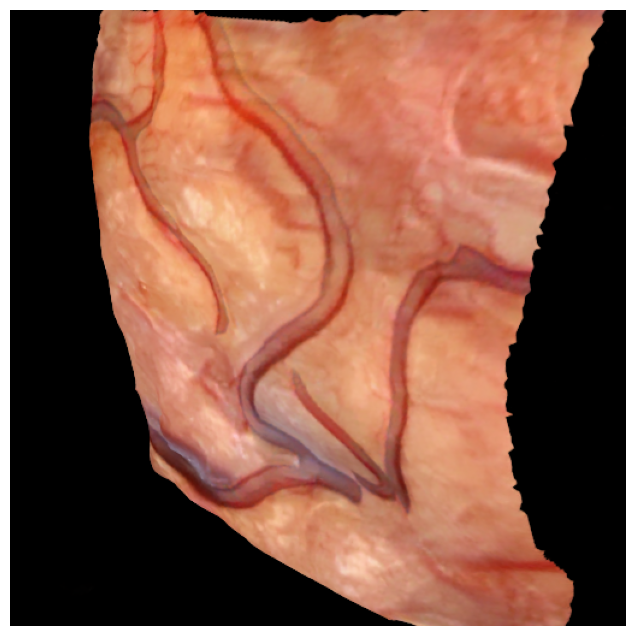

In [11]:
visualize_rgb_tensor(rgb_image)

In [ ]:
# 4. Compute some loss on the RGB image
loss = some_loss_function(rgb_image)  # Define your loss function

# 5. Backpropagate through the image
loss.backward()

# 6. Now you can access gradients in the model parameters
# For example:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name}: {param.grad.norm()}")